In [15]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

nltk.download('stopwords')
nltk.download('punkt')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ssharma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ssharma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
df = pd.read_csv('./dataset/clean_data.csv').head(1000)

styled_df = df.head(5).style
styled_df.set_table_styles([
    {
        "selector": "th",
        "props": [
            ("color", "black"),
            ("background-color", "#FFEEDD")
        ]
    }
])


,is_profane,text
0,0,Then go to the village pump and suggest they change the language in how a RFC should be set up.
1,1,"ANTI GREEK NATIONALIS -WIKIPEDIA Hi Alexikoua, Yous should not vandalise Wikipedia by editing false information.You may be a chauvinist but you can not edit false information on Wikipedia.There is nowhere 6 percent greeks in Albania. ... THIS IS THE REAL INFORMATION BECAUSE IT IS THE CENSUS. DO NOT VANDALISE WIKIPEDIA WITH YOUR MILITANT IDEAS."
2,1,Dis hoe wasnt dis violent on Lottery Ticket 😂😂
3,0,It is better for Atabay not helping the banned vandals pushing their POV.
4,0,"""is in CamelCase. """"SiCKO"""" is not CamelCase, so the CamelCase rule R. Baley mentions is inapplicable. """


In [8]:
df.rename(columns={'is_profane': 'target'}, inplace=True)
df.info()
df.shape



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  1000 non-null   int64 
 1   text    1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


(1000, 2)

In [10]:
ps = PorterStemmer()

def tokenize(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []

    for i in text:
        if i.isalnum() and i not in stopwords.words('english') and i not in string.punctuation:
            y.append(ps.stem(i))

    

    return  " ".join(y) 


tokenize('Then go to the village pump and suggest they change the language in how a RFC should be set up.')

'go villag pump suggest chang languag rfc set'

In [13]:
df['transformed'] = df['text'].apply(tokenize)
df

,target,text,transformed
0,0,Then go to the village pump and suggest they c...,go villag pump suggest chang languag rfc set
1,1,ANTI GREEK NATIONALIS -WIKIPEDIA \r\n\r\nHi Al...,anti greek nationali hi alexikoua you vandalis...
2,1,Dis hoe wasnt dis violent on Lottery Ticket 😂😂,di hoe wasnt di violent lotteri ticket
3,0,It is better for Atabay not helping the banned...,better atabay help ban vandal push pov
4,0,"""is in CamelCase. """"SiCKO"""" is not CamelCase,...",camelcas sicko camelcas camelcas rule baley me...
...,...,...,...
995,1,like fuccck man why yall bitches wearing wigs...,like fuccck man yall bitch wear wig school
996,1,I just wanna travel the world with my bitches 😩,wan na travel world bitch
997,1,"FUCK YOU BITCH\r\nKiss my ass, you dickless tr...",fuck bitch kiss ass dickless troll hope never ...
998,0,"depends what bbg stands for.\r\n\r\nAlso, was ...",depend bbg stand also list psp game delet anym...


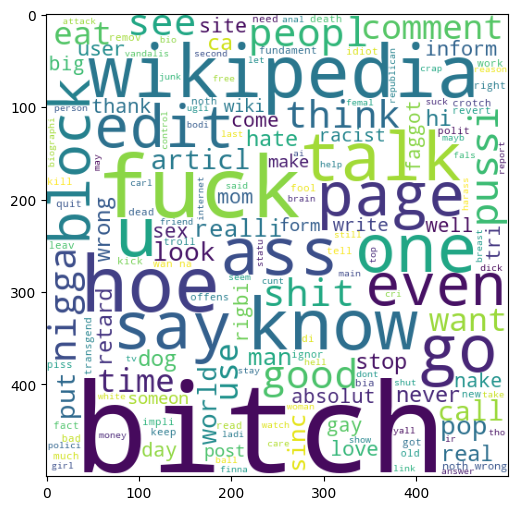

In [16]:
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')
profane = wc.generate(df[df['target'] == 1]['transformed'].str.cat(sep=' '))
plt.figure(figsize=(15,6))
plt.imshow(profane)
plt.show()

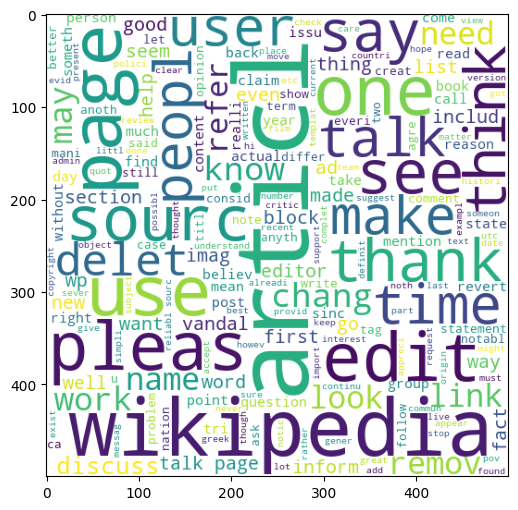

In [17]:
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')
sane = wc.generate(df[df['target'] == 0]['transformed'].str.cat(sep=' '))
plt.figure(figsize=(15,6))
plt.imshow(sane)
plt.show()

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5)

In [20]:
from sklearn.model_selection import train_test_split

X = df['transformed']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [29]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier


clfs = {
    # 'svc': SVC(kernel='sigmoid', gamma=1.0),
    'knc': KNeighborsClassifier(),
    'mnb': MultinomialNB(),
    'dtc': DecisionTreeClassifier(max_depth=5),
    'rfc': RandomForestClassifier(n_estimators=50, random_state=2),
    'xgb': XGBClassifier(n_estimators=50, random_state=2),
    'hard-vote': VotingClassifier(
        estimators=[
            ('mnb', MultinomialNB()),
            ('rfc', RandomForestClassifier(n_estimators=50, random_state=2)),
            ('xgb', XGBClassifier(n_estimators=50, random_state=2))
        ],
        voting='hard'
    ),
    'soft-vote': VotingClassifier(
        estimators=[
            ('mnb', MultinomialNB()),
            ('rfc', RandomForestClassifier(n_estimators=50, random_state=2)),
            ('xgb', XGBClassifier(n_estimators=50, random_state=2))
        ],
        voting='soft'
    )
}

In [30]:
from sklearn.metrics import accuracy_score, precision_score


for name, clf in clfs.items():
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    print()
    print(f"For {name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")


For knc
Accuracy: 0.9
Precision: 0.8571428571428571

For mnb
Accuracy: 0.93
Precision: 0.9444444444444444

For dtc
Accuracy: 0.95
Precision: 1.0

For rfc
Accuracy: 0.94
Precision: 0.8461538461538461

For xgb
Accuracy: 0.92
Precision: 0.8888888888888888

For hard-vote
Accuracy: 0.94
Precision: 0.95

For soft-vote
Accuracy: 0.93
Precision: 1.0


In [34]:
def check_profanity(text):
    txt = tfidf.transform([text])

    for name, clf in clfs.items():
        predict = clf.predict(txt)
        predict = 'not-profane' if predict == 0 else 'profane'
        print(f"{name} predicted {text} -> {predict}")
    print("-"*40)


testData = ["Hi Bruv, Hope you are doing well", "Love this product", "She's a hoe", 'Suck water from bottle', "write the article ibtch", "Idiot, A cup of cum for you! DRINK IT ALL PLZ", "A cup of cum for you! DRINK IT ALL PLZ"]

for text in testData:
    check_profanity(text)

knc predicted Hi Bruv, Hope you are doing well -> not-profane
mnb predicted Hi Bruv, Hope you are doing well -> not-profane
dtc predicted Hi Bruv, Hope you are doing well -> not-profane
rfc predicted Hi Bruv, Hope you are doing well -> not-profane
xgb predicted Hi Bruv, Hope you are doing well -> profane
hard-vote predicted Hi Bruv, Hope you are doing well -> not-profane
soft-vote predicted Hi Bruv, Hope you are doing well -> not-profane
----------------------------------------
knc predicted Love this product -> not-profane
mnb predicted Love this product -> not-profane
dtc predicted Love this product -> not-profane
rfc predicted Love this product -> not-profane
xgb predicted Love this product -> profane
hard-vote predicted Love this product -> not-profane
soft-vote predicted Love this product -> profane
----------------------------------------
knc predicted She's a hoe -> profane
mnb predicted She's a hoe -> profane
dtc predicted She's a hoe -> profane
rfc predicted She's a hoe -> pro